In [1]:
# Propagation from AZ/EL observations
# Perturbation:
# N/A
# Maneuver: 
# No

# IOD
# Given from propagation_issX

# Obserbation:
# AZ/EL
# TOD / IERS_2010

# Output:
# TBD


In [1]:
%matplotlib inline

from math import radians, pi, degrees
import pandas as pd
import numpy as np
import plotly.express as px


import orekit
vm = orekit.initVM()

from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime
setup_orekit_curdir()

from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.propagation.analytical import KeplerianPropagator
from org.orekit.time import AbsoluteDate, TimeScalesFactory, TimeScale
from org.orekit.utils import Constants
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.attitudes import LofOffset
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid
from org.orekit.forces.drag import IsotropicDrag
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.maneuvers import ImpulseManeuver
from org.orekit.frames import FramesFactory, LOFType, EOPHistory
from org.orekit.models.earth.atmosphere import HarrisPriester
from org.orekit.orbits import CircularOrbit, OrbitType, PositionAngle
from org.orekit.propagation import PropagationType, SpacecraftState
from org.orekit.propagation.events import DateDetector, EventEnablingPredicateFilter, PythonEnablingPredicate,\
     PositionAngleDetector, PythonEventDetector, AbstractDetector, EventDetector
from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder, DSSTPropagatorBuilder, \
     ClassicalRungeKuttaIntegratorBuilder, EulerIntegratorBuilder
from org.orekit.propagation.semianalytical.dsst.forces import DSSTAtmosphericDrag, DSSTNewtonianAttraction, DSSTZonal
from org.orekit.time import AbsoluteDate, TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions, PVCoordinatesProvider
from orekit.pyhelpers import absolutedate_to_datetime
from org.hipparchus.linear import RealMatrix
from org.hipparchus.linear import QRDecomposer, AbstractRealMatrix
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
from org.orekit.estimation.leastsquares import BatchLSEstimator
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.propagation.conversion import AbstractPropagatorBuilder

from org.orekit.estimation.measurements import AngularAzEl
from org.orekit.estimation.measurements import ObservableSatellite
from org.orekit.estimation.measurements import GroundStation
from org.orekit.estimation.sequential import KalmanEstimatorBuilder
from org.orekit.estimation.sequential import KalmanEstimator
from org.orekit.estimation.sequential import KalmanEstimation,AbstractCovarianceMatrixProvider
from org.orekit.estimation.measurements import *
from org.orekit.estimation.iod import IodGooding, IodLaplace

from orekit.pyhelpers import absolutedate_to_datetime, datetime_to_absolutedate, JArray_double2D
from collections import namedtuple
from org.orekit.time import Month
from orekit import JArray

from org.orekit.estimation.sequential import KalmanEstimator, KalmanEstimatorBuilder, CovarianceMatrixProvider, ConstantProcessNoise
from org.orekit.orbits import Orbit
from org.hipparchus.linear import MatrixUtils

In [18]:
# ADS Inputs
a = 6500000.0  
e = 0.02
i = radians(98.0)     
omega = radians(0.2)   # perigee argument
raan = radians(90.0)  # right ascension of ascending node
lv = radians(3.0)#0.1)    # True anomaly

#mass = 625.0
utc = TimeScalesFactory.getUTC()
initialDate = AbsoluteDate(2020, 1, 1, 0, 0, 00.000, utc)

## Inertial frame where the satellite is defined
inertialFrame =  FramesFactory.getTOD(IERSConventions.IERS_2010, False)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         inertialFrame)

## Orbit construction as Keplerian
initialOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, initialDate, Constants.WGS84_EARTH_MU)

# Orbit propagator parameters
prop_min_step = 60.0 # s
prop_max_step = 300.0 # s
prop_position_error = 100.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-3
estimator_max_iterations = 25
estimator_max_evaluations = 35


In [19]:
from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)
# integratorBuilder = EulerIntegratorBuilder(10.0)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngle
kepPropagatorBuilder = NumericalPropagatorBuilder(initialOrbit,
                                               integratorBuilder,
                                               PositionAngle.MEAN,
                                               estimator_position_scale)

# propagatorBuilder.setMass(1000.0)
# propagatorBuilder.setAttitudeProvider(nadirPointing)

In [20]:
# Earth gravity field with degree 20 and order 20
from org.orekit.forces.gravity.potential import GravityFieldFactory
gravityProvider = GravityFieldFactory.getConstantNormalizedProvider(20,20)

from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
gravityAttractionModel = HolmesFeatherstoneAttractionModel(inertialFrame, gravityProvider)
kepPropagatorBuilder.addForceModel(gravityAttractionModel)

moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()


In [21]:
from org.orekit.utils import ParameterDriver
plst = kepPropagatorBuilder.getPropagationParametersDrivers()

dragCoefficient = ParameterDriver('Cd', 2.2, 1.0, 1.0, 3.0)
dragCoefficient.setSelected(True)
plst.add(dragCoefficient)

rpCoeffReflection = ParameterDriver('Cr', 1.5, 1.0, 1.0, 2.0)
rpCoeffReflection.setSelected(True)
plst.add(rpCoeffReflection)

estmDMCAcceleration = ParameterDriver('DMC', 0.0001, 1.0, -1.0e-2, -1.0e-2)
estmDMCAcceleration.setSelected(True)
plst.add(estmDMCAcceleration)



In [22]:
def initCov(initialCov, initData):
    for i in range(0,6):
        initialCov.setEntry(i, i, 1.0);
        for j in range(0,i):
            initialCov.setEntry(i, j, initData[j]);
            initialCov.setEntry(j, i, initData[j]);
            #print(initData[j])
    return initialCov

def getAzElDate(datetime, ref):
    year = int(datetime[1:5])
    month = int(datetime[6:8])
    day = int(datetime[9:11])
    hour = int(datetime[12:14])
    minute = int(datetime[15:17])
    second = int(datetime[18:20])
    return AbsoluteDate(year, Month.getMonth(month), day, hour, minute, 0.0, ref)#TimeScalesFactory.getUT1(IERSConventions.IERS_2010, False))    

In [23]:
# Creation of Noise matrix

matrixSize = 9


Q = MatrixUtils.createRealDiagonalMatrix([1e1, 1e1, 1e1, 1e1, 1e1, 1e1, 1e1, 1e1, 1e1])
# Creation of initial Covariance matrix
from org.hipparchus.linear import Array2DRowRealMatrix
initialCov = Array2DRowRealMatrix(matrixSize,matrixSize)
# From Orbdetpy, Settings.java
#     public double[] estmCovariance = new double[]{25E6, 25E6, 25E6, 1E2, 1E2, 1E2, 1.00, 0.25, 1E-6, 1E-6, 1E-6};
initData = [25e6, 1.0, 3.14, 3.14, 3.14, 3.14, 1.00, 1.00, 1e-1, 1e-1,1e-1]
#initData = [25e6, 1.0, 1.1, 1.1, 1.1, 1.1, 1.00, 0.25, 1e-1]

initialCov = initCov(initialCov, initData)

    
from org.orekit.estimation.sequential import KalmanEstimatorBuilder, KalmanEstimation
from org.orekit.orbits import CartesianOrbit, Orbit
from org.orekit.utils import TimeStampedPVCoordinates

# Build the Kalman filter
processNoise = ConstantProcessNoise(initialCov, Q)
kalman = KalmanEstimatorBuilder().addPropagationConfiguration(kepPropagatorBuilder, processNoise) # KalmanEstimatorBuilder

# Uncomment to concider estimated parameters
#kalman.estimatedMeasurementsParameters(plst)
filter = kalman.build() # KalmanEstimator
print(filter.getPropagationParametersDrivers(True).getDrivers())
print(type(filter))
from org.orekit.estimation.sequential import KalmanObserver
#a = KalmanObserver()
#filter.setObserver(a)

#from org.orekit.estimation.sequential import KalmanObserver 
#observer = KalmanObserver
#filter.setObserver(a)

[Cd = 2.2, Cr = 1.5, DMC = -0.01]
<class 'org.orekit.estimation.sequential.KalmanEstimator'>


In [24]:
# Build ObservedMeasurement
#Open and collect data from csv
file = pd.read_csv("export_all_NoPert_Man.csv")
az = file['azimuth']
el = file['elevation']
datetime = file['pv']
idx = datetime[0].find(',')

errDeg = 0.001 #10*0.000277778 #1 arcsec
# TBD - 1.0 makes unstable iterations of the EKF, TBD effect on the EKF
azBaseWeight = 0.5
elBaseWeight = 0.5

# Load values
# Ground station creation
#frame = FramesFactory.getTOD(False)
#frame = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
frame = FramesFactory.getTOD(IERSConventions.IERS_2010, False)

earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         frame)
longitude = radians(21.038)
latitude  = radians(67.8790708)
altitude  = 527.0
station = GeodeticPoint(latitude, longitude, altitude)
stationFrame = TopocentricFrame(earth, station, "Kiruna")


ObsSat= ObservableSatellite(0) # From R5
EKF_a = []  
EKF_e = [] 
EKF_i = []     
EKF_omega = []  
EKF_raan = []  
EKF_lv = [] 
newCovMatrix = []

Elt1 = []
Elt2 = []
Elt3 = []
Elt4 = []
Elt5 = []
Elt6 = []

iFail = 0
FAIL_MAX = 50

for j in range(0,len(az)):
    date = getAzElDate(datetime[j], utc)
    orekitAzEl = AngularAzEl(GroundStation(stationFrame),
                    date,
					JArray('double')([radians(az[j]),radians(el[j])]),
                    JArray('double')([radians(errDeg),radians(errDeg)]),
                    JArray('double')([azBaseWeight,elBaseWeight]),
                    ObsSat)
    try:
        filter.estimationStep(orekitAzEl)
        
        newEstimatedState = filter.getPhysicalEstimatedState()

        EKF_a.append(newEstimatedState.getEntry(0))
        EKF_e.append(newEstimatedState.getEntry(1))
        EKF_i.append(newEstimatedState.getEntry(2))
        EKF_omega.append(newEstimatedState.getEntry(3))
        EKF_raan.append(newEstimatedState.getEntry(4))
        EKF_lv.append(newEstimatedState.getEntry(5))
        
        newCovMatrix.append(filter.getPhysicalEstimatedCovarianceMatrix())
           
        Elt1.append(newCovMatrix[-1].getEntry(1, 1))
        Elt2.append(newCovMatrix[-1].getEntry(2, 2))
        Elt3.append(newCovMatrix[-1].getEntry(3, 3))
        Elt4.append(newCovMatrix[-1].getEntry(4, 4))
        Elt5.append(newCovMatrix[-1].getEntry(5, 5))
        Elt6.append(newCovMatrix[-1].getEntry(6, 6))

    except:
        print('Problem iteration: ', j)
        iFail += 1
        if iFail >= FAIL_MAX:
            break
        #print(ValueError)
    #a = filter.getCurrentDate()
    #print(a,newEstimatedState)

#print(orekitAzEl.getDate())
a = filter.getCurrentDate()
print(a,newEstimatedState)


2020-01-03T00:00:00.000 {6,791,671.807572911; 0.2403671807; 1.7069306906; -0.1696051717; 1.5741482801; 186.5611375263; 2.2; 1.5; -0.01}


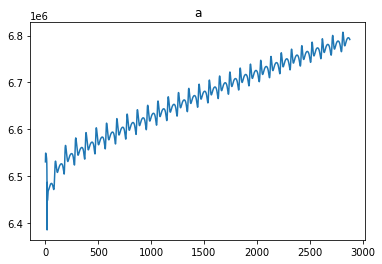

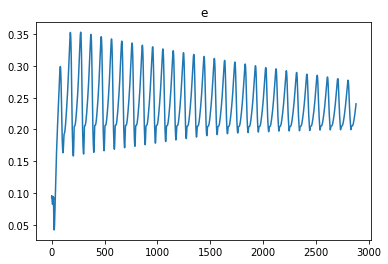

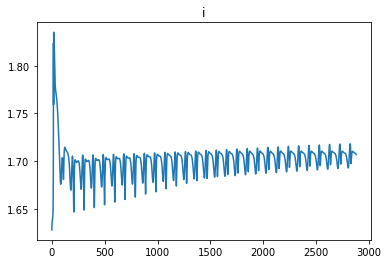

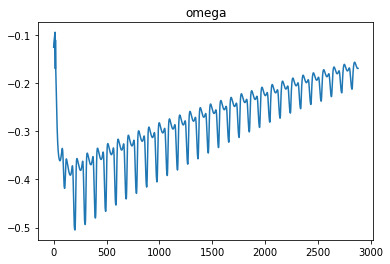

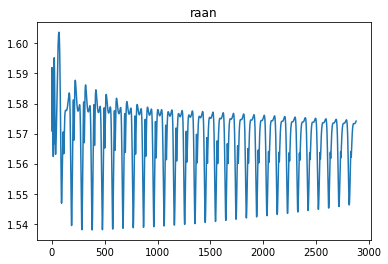

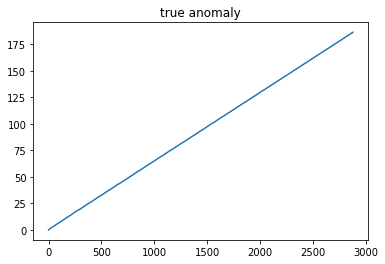

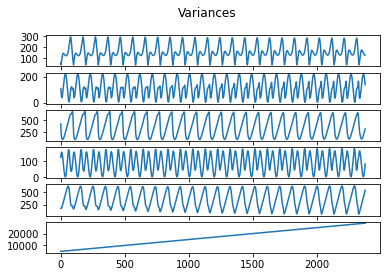

In [25]:
import matplotlib.pyplot as plt
plt.plot(EKF_a)
plt.title('a')
plt.show()
plt.plot(EKF_e)
plt.title('e')
plt.show()
plt.plot(EKF_i)
plt.title('i')
plt.show()
plt.plot(EKF_omega)
plt.title('omega')
plt.show()
plt.plot(EKF_raan)
plt.title('raan')
plt.show()
plt.plot(EKF_lv)
plt.title('true anomaly')
plt.show()

fig, axs = plt.subplots(6)
fig.suptitle('Variances')
axs[0].plot(Elt1[500:])
axs[1].plot(Elt2[500:])
axs[2].plot(Elt3[500:])
axs[3].plot(Elt4[500:])
axs[4].plot(Elt5[500:])
axs[5].plot(Elt6[500:])